# Alphalens Quickstart Template

In [2]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data import factset, USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.factors import Returns, SimpleMovingAverage, CustomFactor, RSI

from alphalens.performance import mean_information_coefficient
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_information_tear_sheet, create_returns_tear_sheet


from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.experimental import risk_loading_pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
import quantopian.pipeline.data.factset.estimates as fe
from quantopian.pipeline.factors import Returns


/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:16: ZiplineDeprecationWarning: PsychSignal datasets stopped updating on Quantopian on May 1, 2020.
PsychSignal data prior to May 2020 is still available for use on Quantopian;
however, the dataset has stopped updating. For more information see:
https://www.quantopian.com/posts/psychsignal-trader-mood-update

  app.launch_new_instance()


## Define Your Alpha Factor Here

Spend your time in this cell, creating good factors. Then simply run the rest of the notebook to analyze `factor_to_analyze`!

In [3]:
def make_pipeline():
    
    value = Fundamentals.ebit.latest / Fundamentals.enterprise_value.latest
    quality = Fundamentals.roe.latest
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )
    mean_close_10 = SimpleMovingAverage(
        inputs=[USEquityPricing.close],
        window_length=10
    )
    mean_close_30 = SimpleMovingAverage(
        inputs=[USEquityPricing.close],
        window_length=30
    )
    percent_difference = (mean_close_10 - mean_close_30) / mean_close_30

    # We winsorize our factor values in order to lessen the impact of outliers
    # For more information on winsorization, please see
    # https://en.wikipedia.org/wiki/Winsorizing
    value_winsorized = value.winsorize(min_percentile=0.05, max_percentile=0.95)
    quality_winsorized = quality.winsorize(min_percentile=0.05, max_percentile=0.95)
    sentiment_score_winsorized = sentiment_score.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
    )

    percent_difference_winsorized = percent_difference.winsorize(
        min_percentile=0.1,
        max_percentile=0.9
    )

    recent_returns = Returns(window_length=5)

    fq1_eps_cons = fe.PeriodicConsensus.slice('EPS', 'qf', 2)
    fq1_eps_cons_up = fq1_eps_cons.up.latest
    fq1_eps_cons_down = fq1_eps_cons.down.latest

    fq_tot = fq1_eps_cons_up - fq1_eps_cons_down
    fq_tot_windsorized = fq_tot.winsorize(min_percentile=0.01, max_percentile=0.99)

    # Here we combine our winsorized factors, z-scoring them to equalize their influence
    combined_factor = (
            value_winsorized.zscore() +
            quality_winsorized.zscore() +
            sentiment_score_winsorized.zscore() +
            0.05 * percent_difference_winsorized.zscore() +
            0.05 * fq_tot_windsorized.zscore() +
            0.1 * recent_returns.zscore()

    )
    
    factor_to_analyze = combined_factor
    
    sector = Sector()
    
    return Pipeline(
        columns = {'factor_to_analyze': factor_to_analyze, 'sector': sector},
        screen = QTradableStocksUS() & factor_to_analyze.notnull() & sector.notnull()
    )

factor_data = run_pipeline(make_pipeline(), '2017-4-29', '2019-4-29')
pricing_data = get_pricing(factor_data.index.levels[1], '2017-4-29', '2019-4-29', fields='open_price')

## Determine The Decay Rate Of Your Alpha Factor.

Dropped 13.3% entries from factor data: 13.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


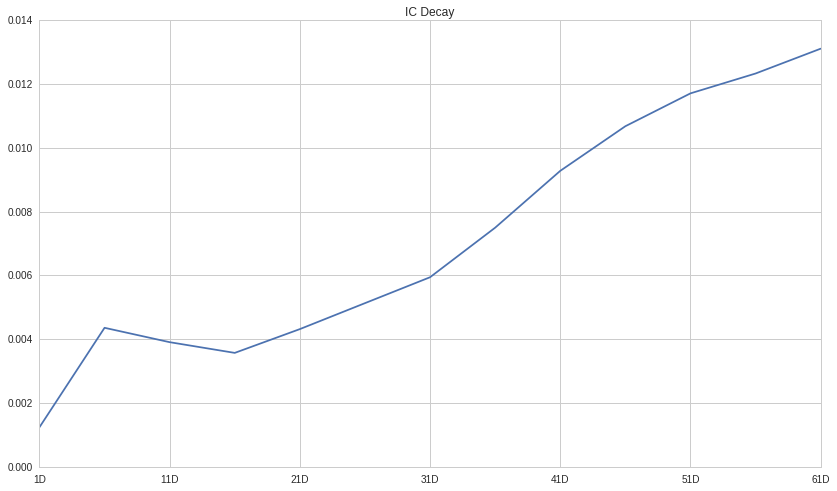

In [4]:
longest_look_forward_period = 63 # week = 5, month = 21, quarter = 63, year = 252
range_step = 5

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['factor_to_analyze'],
    prices = pricing_data,
    periods = range(1, longest_look_forward_period, range_step)
)

mean_information_coefficient(merged_data).plot(title="IC Decay")

## Create Group Neutral Tear Sheets

Dropped 2.2% entries from factor data: 2.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.003,0.006,0.009
IC Std.,0.053,0.054,0.054
Risk-Adjusted IC,0.050,0.106,0.172
t-stat(IC),1.102,2.352,3.807
p-value(IC),0.271,0.019,0.000
IC Skew,0.083,0.036,-0.070
IC Kurtosis,0.104,-0.354,0.473


/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


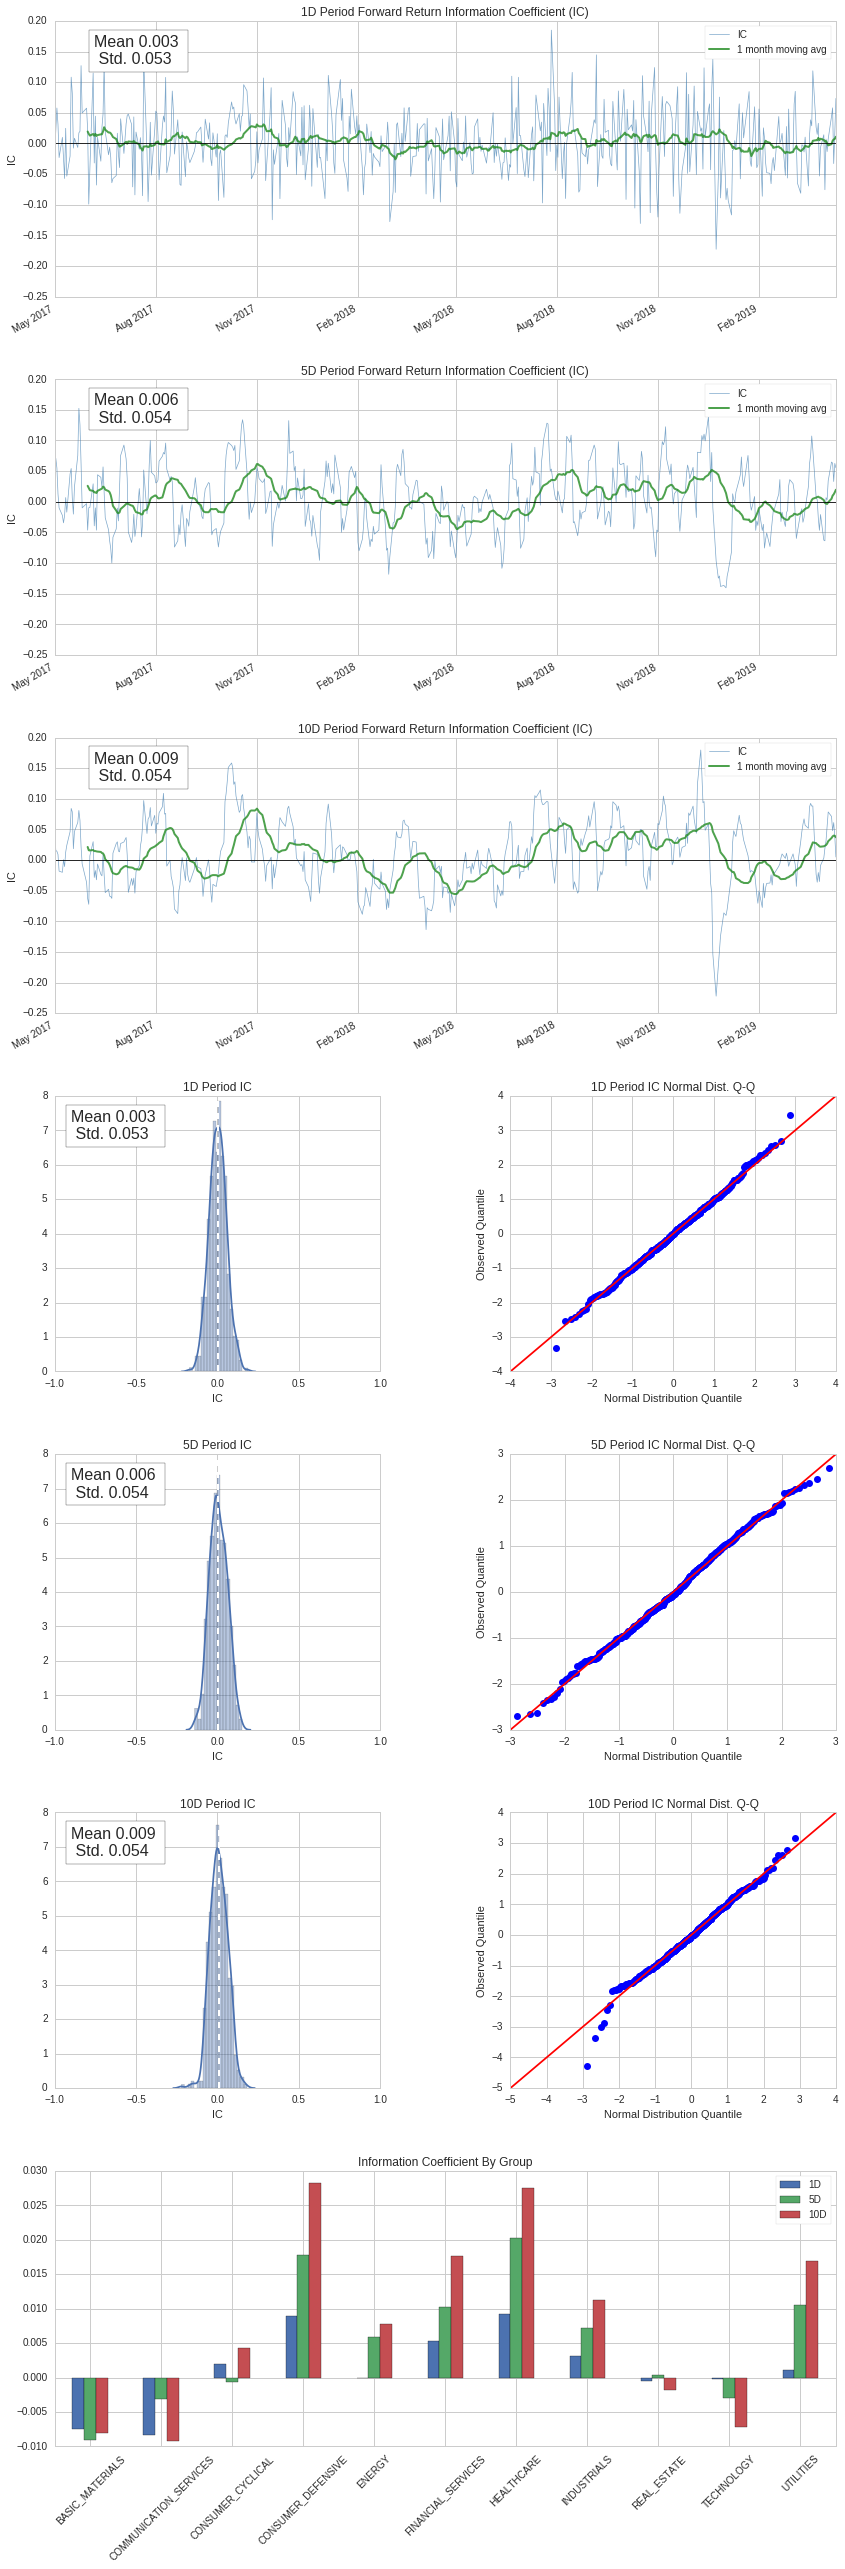

Returns Analysis


,1D,5D,10D
Ann. alpha,0.015,0.016,0.016
beta,-0.080,-0.100,-0.102
Mean Period Wise Return Top Quantile (bps),-0.594,-0.401,-0.097
Mean Period Wise Return Bottom Quantile (bps),-0.028,0.159,0.249
Mean Period Wise Spread (bps),-0.566,-0.551,-0.335


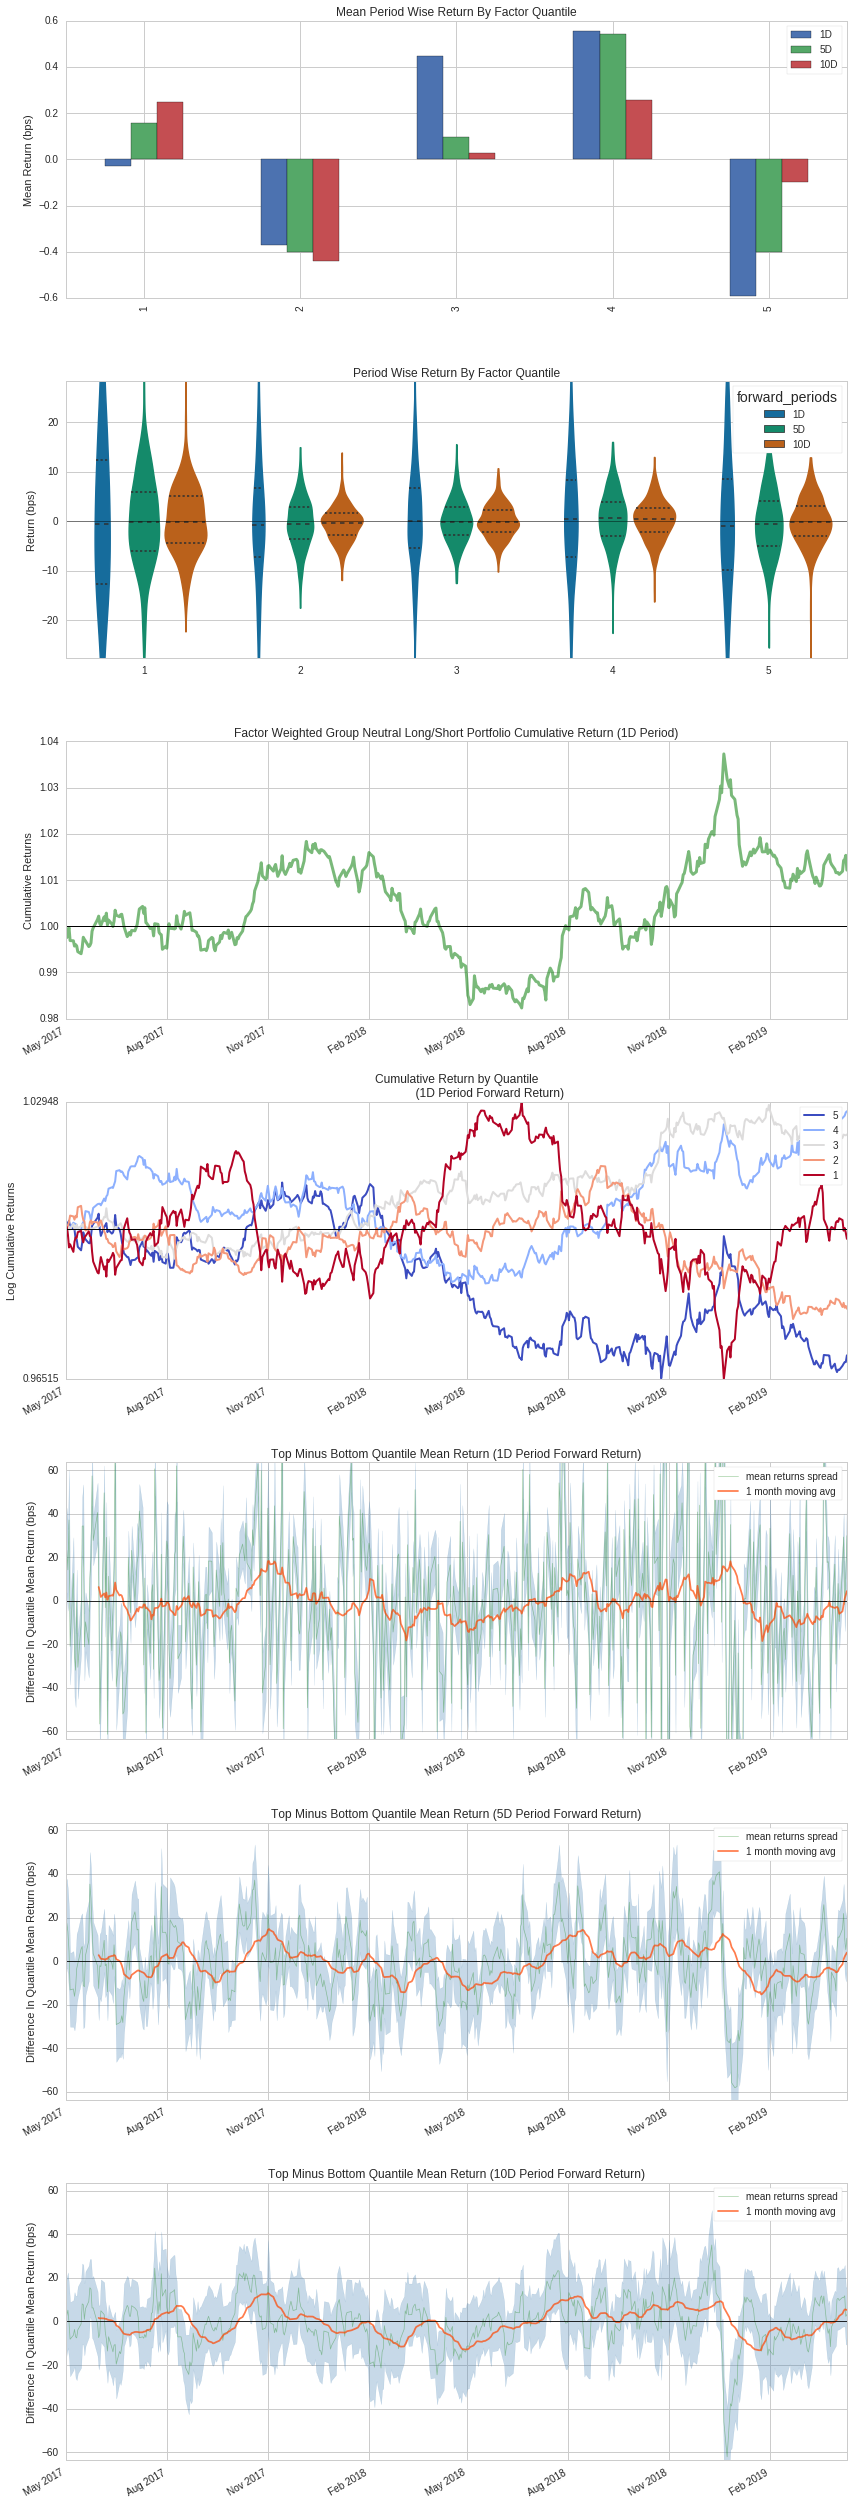

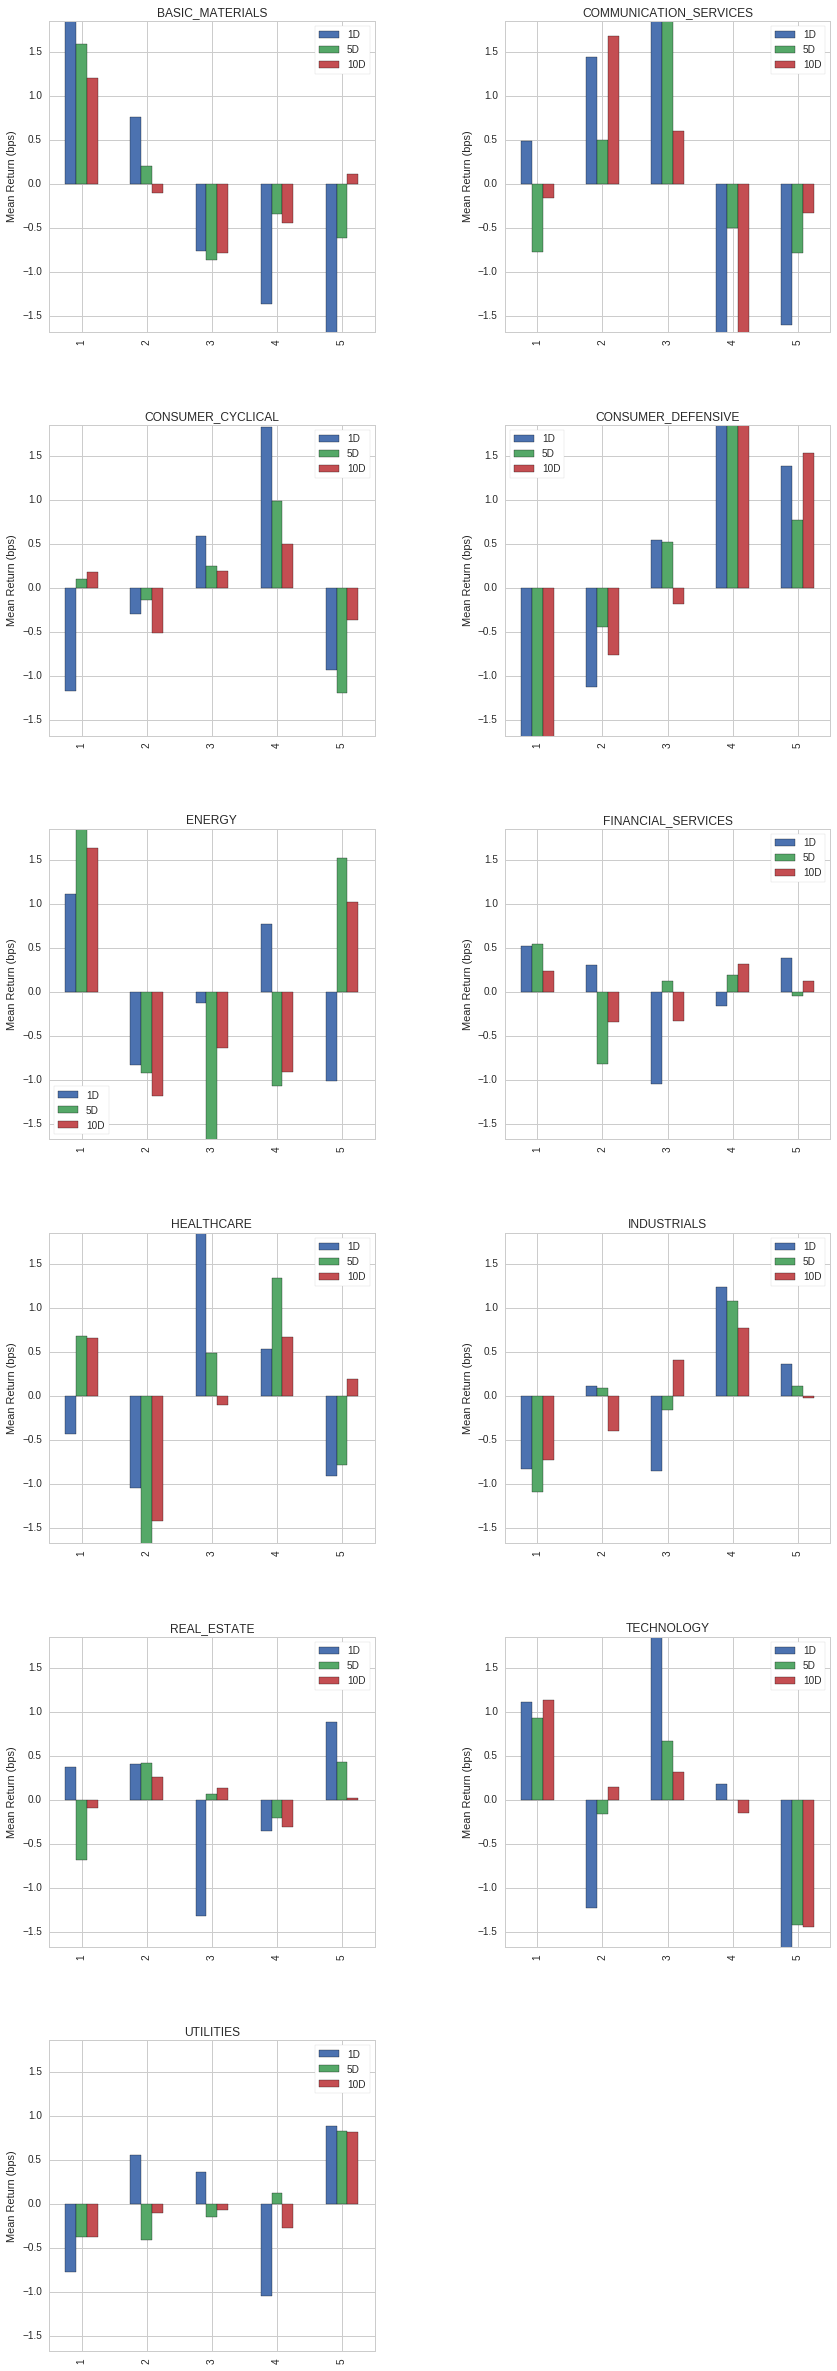

In [5]:
sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['factor_to_analyze'],
    prices = pricing_data,
    groupby = factor_data['sector'],
    groupby_labels = sector_labels,
    binning_by_group = True,
    periods = (1,5,10)
)

create_information_tear_sheet(merged_data, by_group=True, group_neutral=True)
create_returns_tear_sheet(merged_data, by_group=True, group_neutral=True)